<a href="https://colab.research.google.com/github/kollisujit/Edvancer_deep_learning/blob/main/Music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

In [2]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2022-09-20 17:58:12--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4jw31k5mlzcmgis/genres.tar.gz [following]
--2022-09-20 17:58:12--  https://www.dropbox.com/s/raw/4jw31k5mlzcmgis/genres.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc040a411cc4d005b5c848500fe9.dl.dropboxusercontent.com/cd/0/inline/BtUjTpO-hLU4B6FOfpFe3lNWn0uTNwe1D9z5j6qCIJsIniARutXVyX0hjeUI81hvKT2DRcUcDFUUOYybwJ397MEme94Ixjz4i93rIpXZMY9vyoAabsAxBd92S5unpzGNu-RUAKCUD6gjZvXbg73xM7ue5SznTmsYx5fQm4hq0cBE8A/file# [following]
--2022-09-20 17:58:13--  https://uc040a411cc4d005b5c848500fe9.dl.dropboxusercontent.com/cd/0/inline/BtUjTpO-hLU4B6FOfpFe3lNWn0uTNwe1D9z5j6qCIJsIniARutXVyX0hjeUI81hvKT2DR

In [3]:
import tarfile

In [4]:
data = tarfile.open("genres.tar.gz?dl=0")

In [5]:
data.extractall('./Audiodata')

In [6]:
data.close()

In [7]:
!pip install path


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path
import IPython.display as ipd

In [9]:
import os
os.mkdir('train')
os.mkdir('test')


In [10]:
glob('./train/*')

[]

In [11]:
file_list=list(glob("./Audiodata/genres/blues/*"))

In [13]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [14]:
audio_fpath = "/content/Audiodata/genres/blues/"
audio_clips = os.listdir(audio_fpath)


print("Number of .wav files in audio folder = ",len(audio_clips))

Number of .wav files in audio folder =  100


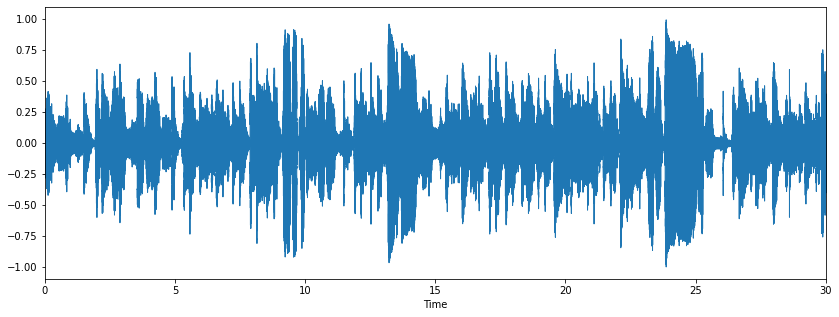

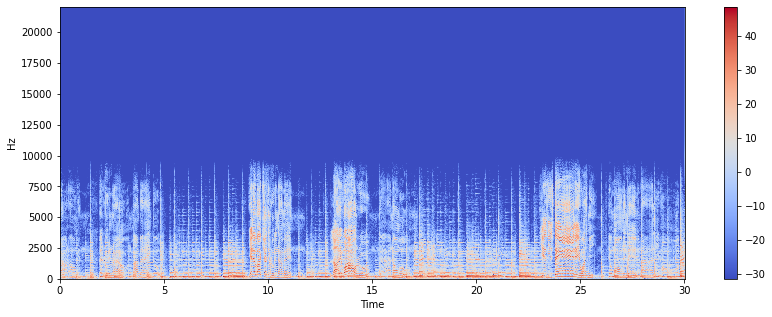

In [15]:
x, sr = librosa.load(audio_fpath+audio_clips[2], sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [16]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [18]:
import csv
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Audiodata/genres/{g}'):
        songname = f'./Audiodata/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.390212,0.136276,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922409,-8.607986,64.494560,...,11.087481,-5.085794,3.976360,-12.859742,12.343859,0.026216,-0.741568,-5.126620,3.303442,blues
1,0.375158,0.198282,1236.574280,1602.309124,2604.150920,0.044626,-148.639175,145.746307,-9.363639,48.453766,...,3.230693,-0.667060,-0.727791,-6.821161,-3.942547,-15.739369,-5.604687,-5.802770,-0.048729,blues
2,0.307921,0.131785,1451.754147,1577.369917,2955.348796,0.061435,-179.395432,136.459244,-26.656363,39.988026,...,-6.954826,-3.544536,-8.051242,-8.959538,-8.424336,-10.558884,-10.788157,-4.693748,-8.638613,blues
3,0.255321,0.085868,1151.340441,1709.193938,2312.577683,0.035339,-301.686279,111.539207,21.895657,16.145590,...,-10.572882,-15.687017,-12.598773,-12.245660,-14.543065,-10.092299,-5.780286,-7.776047,-7.186642,blues
4,0.270313,0.080653,1420.529293,1731.192252,2930.540613,0.063718,-238.518967,120.084557,-4.227884,42.307072,...,-1.384823,0.021881,3.586694,-4.503952,-5.542268,-6.888212,-4.828142,1.735006,-1.888814,blues


In [21]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train


array([3, 5, 5, 2, 6, 1, 3, 2, 5, 3, 5, 6, 5, 8, 3, 6, 4, 0, 2, 8, 1, 7,
       4, 5, 8, 1, 1, 1, 7, 2, 5, 3, 4, 8, 7, 8, 8, 9, 8, 1, 1, 6, 7, 0,
       2, 5, 1, 6, 2, 2, 7, 3, 4, 8, 0, 4, 2, 3, 0, 1, 8, 9, 5, 8, 4, 7,
       0, 3, 6, 3, 6, 9, 3, 3, 9, 0, 2, 6, 5, 9, 0, 7, 3, 4, 8, 5, 4, 6,
       4, 7, 2, 0, 0, 7, 2, 3, 1, 5, 8, 7, 6, 4, 0, 3, 6, 2, 1, 6, 3, 4,
       9, 7, 9, 5, 6, 5, 7, 6, 3, 1, 3, 3, 8, 3, 4, 9, 8, 9, 7, 1, 2, 8,
       2, 7, 5, 1, 1, 4, 5, 5, 9, 6, 7, 8, 2, 5, 1, 9, 2, 2, 1, 4, 9, 2,
       9, 3, 8, 7, 0, 6, 1, 0, 1, 1, 2, 0, 8, 9, 2, 7, 6, 2, 3, 6, 1, 3,
       8, 7, 0, 7, 7, 7, 6, 2, 7, 1, 4, 7, 8, 2, 5, 9, 7, 4, 6, 6, 0, 8,
       9, 9, 7, 0, 8, 4, 4, 2, 5, 1, 0, 2, 8, 5, 0, 0, 0, 4, 1, 5, 4, 6,
       5, 4, 3, 5, 4, 4, 0, 6, 3, 7, 4, 6, 3, 9, 0, 3, 6, 0, 3, 2, 1, 2,
       2, 0, 5, 7, 8, 3, 8, 8, 8, 0, 6, 7, 6, 3, 2, 7, 0, 1, 9, 4, 0, 3,
       1, 8, 2, 7, 0, 0, 6, 4, 7, 6, 4, 7, 9, 2, 1, 5, 4, 1, 4, 5, 6, 3,
       4, 3, 0, 7, 6, 5, 6, 9, 9, 9, 8, 4, 6, 7, 8,

In [24]:
from tensorflow.keras.layers import Dense, Activation
model_ann = models.Sequential()
model_ann.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(layers.Dense(128, activation='relu'))
model_ann.add(layers.Dense(64, activation='relu'))
model_ann.add(layers.Dense(10, activation='softmax'))
X_train.shape[1]

26

In [25]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
print("Fit model on training data")
history = model_ann.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20
)

Fit model on training data
Epoch 1/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9987
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9987
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9987
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9987
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9975
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9975
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9987
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9975
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9987
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9987
Epoch 11/20


In [32]:
test_loss, test_acc = model_ann.evaluate(X_test,y_test)
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

7/7 [==============================] - 0s 3ms/step - loss: 2.0954 - accuracy: 0.6500
test_acc:  0.6499999761581421
test_loss:  2.0953848361968994


In [33]:
predictions = model_ann.predict(X_test)
print("Predicted : " ,predictions[0])
print("Actual : ",y_test[0])

Predicted :  [4.92220579e-07 3.59437104e-06 1.16118770e-06 3.99956576e-07
 9.05966341e-01 1.44384990e-06 3.07283821e-09 4.00570389e-05
 9.39744934e-02 1.20065615e-05]
Actual :  4
